# Q3
#### What types of characters do successful directors choose ? 
#### How diverse the directors are in their character choices ? 
#### Can we find very successful directors that always use the same type of characters or others that vary a lot in their personas choices ?

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy
import copy

from helpers.readers import read_dataframe
DATA_PATH = './generated/annotations_2023/'
DATA_PATH_GENERATED = './generated/'

# Load dataset nedded

In [16]:
character_movie_directors=pd.read_parquet(os.path.join(DATA_PATH, "character_movie_directors.parquet"), engine='pyarrow')

In [17]:
character_movie_directors.head()
print('There are {} chractors with chractor types in the dataset'.format(len(character_movie_directors)))

There are 37749 chractors with chractor types in the dataset


In [18]:
# Check for missing values
print(character_movie_directors.isnull().sum())

Wikipedia movie ID       0
Freebase movie ID        0
Movie name               0
Character name           0
tconst                   0
directors                0
freebase                 0
imdb                     0
movieid_charactername    0
topic                    0
topic_dist               0
dtype: int64


In [2]:
cmu_movies = read_dataframe(
    name='cmu/movies',
    preprocess=True,
    usecols=[
        "Wikipedia movie ID",
        "Freebase movie ID",
        "Movie name",
        "Movie release date",
        "Movie box office revenue",
        "Movie runtime",
        "Movie languages",
        "Movie countries",
        "Movie genres",
    ]
)
mapping_f_i = read_dataframe(name='mapping_freebase_imdb')
imdb_ratings = read_dataframe(name='imdb/ratings')
imdb_crew = read_dataframe(name='imdb/crew')
imdb_people = read_dataframe(name='imdb/names')

Preprocess logs:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Fixed 'Hunting Season' release year 1010 => 2010
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
✅ Replaced Hariyani with Haryanvi
✅ Replaced Saami with Sami
✅ The Flying Scotsman (1929 film) country fix
✅ Ukranian SSR fix
✅ Palestinian territories fix
✅ Fixed huge runtimes
✅ Removed series


In [3]:
movies = cmu_movies.drop(['Movie release Day', 'Movie release Month'], axis=1).copy()
movies.rename(
    columns={
        'Wikipedia movie ID': 'wikipediaID',
        'Freebase movie ID': 'freebaseID',
        'Movie name': 'title',
        'Movie box office revenue': 'revenue',
        'Movie runtime': 'runtime',
        'Movie languages': 'languages',
        'Movie countries': 'countries',
        'Movie genres': 'genres',
        'Movie release Year': 'release',
    },
    inplace=True,
)
movies = movies.merge(
    right=mapping_f_i.drop_duplicates(subset='freebase'),
    left_on='freebaseID', right_on='freebase', how='left'
).rename(columns={'imdb': 'tconst'}).drop('freebase', axis=1)
movies.tconst.duplicated().sum()
movies.drop_duplicates(subset='tconst', inplace=True)
movies = movies.merge(
    right=imdb_ratings.rename(columns={'averageRating': 'rating', 'numVotes': 'votes'}),
    on='tconst', how='left',
)
movies = movies.merge(right=imdb_crew.drop('writers', axis=1), on='tconst', how='left')
movies = movies.set_index('tconst')

In [5]:
nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()
directors = directors.set_index('nconst')

In [6]:
directors.head()

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467"
nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0047296,tt0078788,tt0070849,tt0068646"
nm0000009,Richard Burton,1925,1984,"actor,soundtrack,producer","tt0087803,tt0057877,tt0059749,tt0061184"
nm0000018,Kirk Douglas,1916,2020,"actor,producer,soundtrack","tt0049456,tt0050825,tt0054331,tt0080736"
nm0000019,Federico Fellini,1920,1993,"writer,director,actor","tt0050783,tt0053779,tt0056801,tt0071129"


In [7]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [8]:
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-30': (directed_movies.score > 30).sum(),
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score


# Apply the metrics on one column (nested)
directors['score'] = directors.apply(metric, axis=1)

# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)

In [11]:
directors.to_parquet(os.path.join(DATA_PATH_GENERATED, "directors_with_score.parquet"), compression= "brotli")

In [21]:
# Get the directors information for the directors who has chracter type information
directors=pd.merge(character_movie_directors, directors, left_on='directors', right_on='nconst', how='left')
directors=directors[['directors', 'primaryName', 'birthYear','deathYear']]
directors=directors.drop_duplicates(subset=['directors'])
directors=directors.set_index('directors')
display(directors.head())
print('There are {} directors in the dataset'.format(len(directors)))

,primaryName,birthYear,deathYear
directors,,,
nm0432380,Miranda July,1974,<NA>
nm0005436,John Singleton,1968,2019
nm0698184,Priyadarshan,1957,<NA>
nm1435925,Eva Jin,<NA>,<NA>
nm0033005,Vicente Aranda,1926,2015


There are 6941 directors in the dataset


In [22]:
# Add primaryName to character_movie_directors
character_movie_directors = character_movie_directors.merge(directors[['directors', 'primaryName']], left_on='directors', right_on='directors', how='left')
display(character_movie_directors.head())
print('There are {} chractors with chractor types in the dataset'.format(len(character_movie_directors)))

KeyError: "['directors'] not in index"

In [35]:
# !pip install memory_profiler
# install and load memory_profiler to use %memit, use %whos to see what's in memory
%reload_ext memory_profiler
%memit
import gc

del imdb_people
del mapping_f_i
del cmu_movies
del imdb_ratings
del imdb_crew

gc.collect()
%memit

peak memory: 9883.61 MiB, increment: 0.19 MiB
peak memory: 7994.19 MiB, increment: 0.00 MiB


# What types of characters do successful directors choose ? 

First, we need to establish a metric to measure movie sucess, and based one it we can assess director success. Drawing upon past exploration and the definition of director success, we can generate the following dataframe containing success scores for directors.

In [23]:
#Define a function to calculate the score of a movie
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [24]:
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-30': (directed_movies.score > 30).sum(),
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score


# Apply the metrics on one column (nested)
directors['score'] = directors.apply(metric, axis=1)

# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)

KeyboardInterrupt: 

# How diverse the directors are in their character choices ? 

In [39]:
# Group by directors
directors_group = character_movie_directors.groupby('directors').agg({'Wikipedia movie ID': lambda x: list(x), 'Freebase movie ID': lambda x: list(x), 'Movie name': lambda x: list(x), 'Character name': lambda x: list(x), 'topic': lambda x: list(x), 'tconst': lambda x: list(x),'primaryName':lambda x: list(x)})
# character_movie_directors_group.head(3)
print('There are {} unique directors who has the chracter type information'.format(directors_group.shape[0]))

There are 6941 unique directors who has the chracter type information


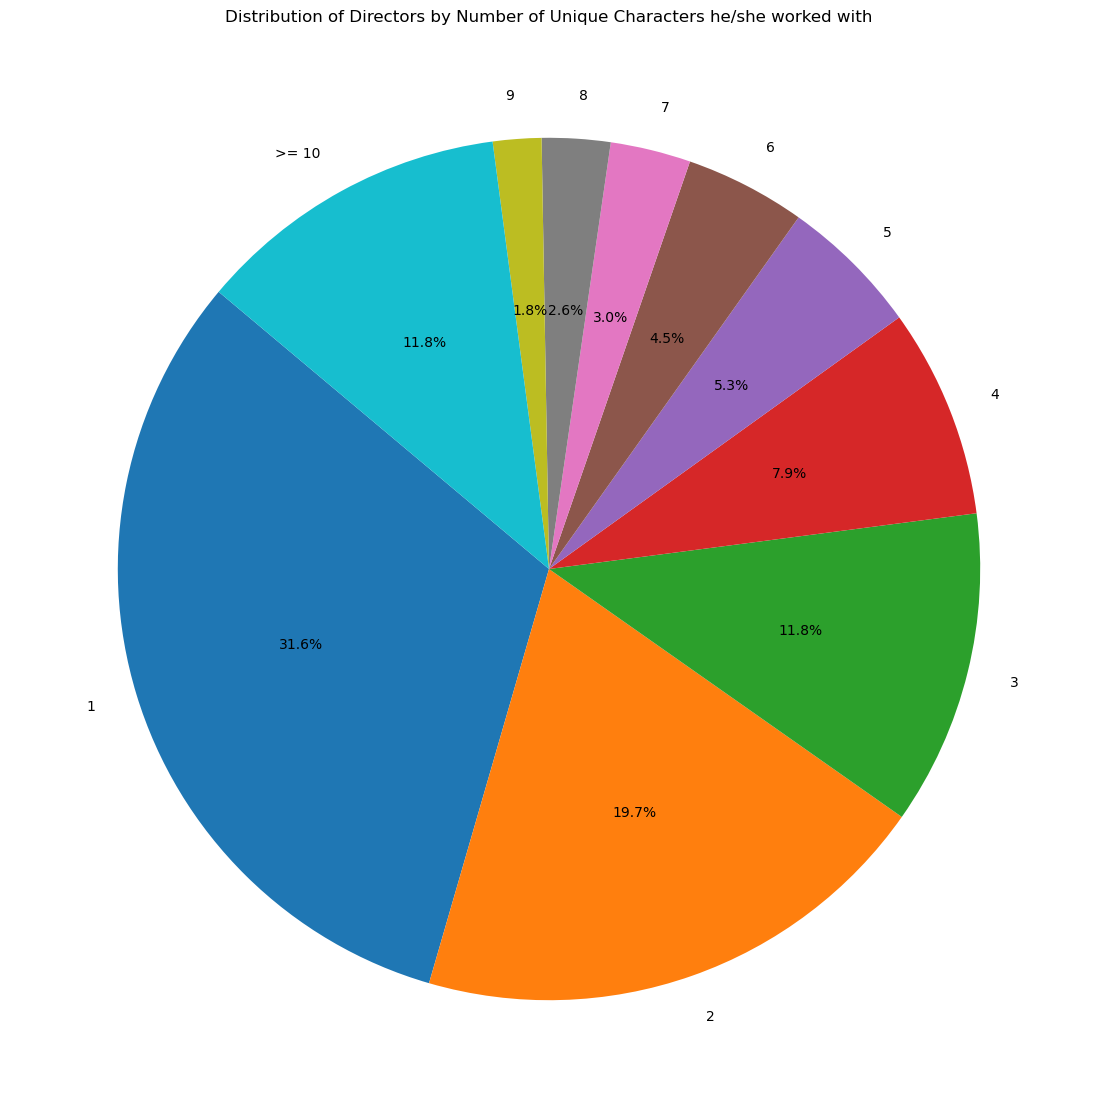

In [40]:
# Calculate the number of unique characters for each director
unique_characters = character_movie_directors.groupby('directors')['topic'].nunique()

# Count the number of directors for each unique number of characters
directors_by_unique_count = unique_characters.value_counts()

# Group together directors with more than 10 unique characters
threshold = 10
large_counts = directors_by_unique_count[directors_by_unique_count.index >= threshold]
directors_by_unique_count = directors_by_unique_count.drop(large_counts.index)
directors_by_unique_count[f'>= {threshold}'] = large_counts.sum()

# Create a pie chart to show the distribution with a custom color map
labels = directors_by_unique_count.index.astype(str)
sizes = directors_by_unique_count.values
colors = plt.cm.tab10(range(len(labels)))

plt.figure(figsize=(14, 14))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Directors by Number of Unique Characters he/she worked with')
plt.show()

Let's have a close look of ten directors with the highest diversity

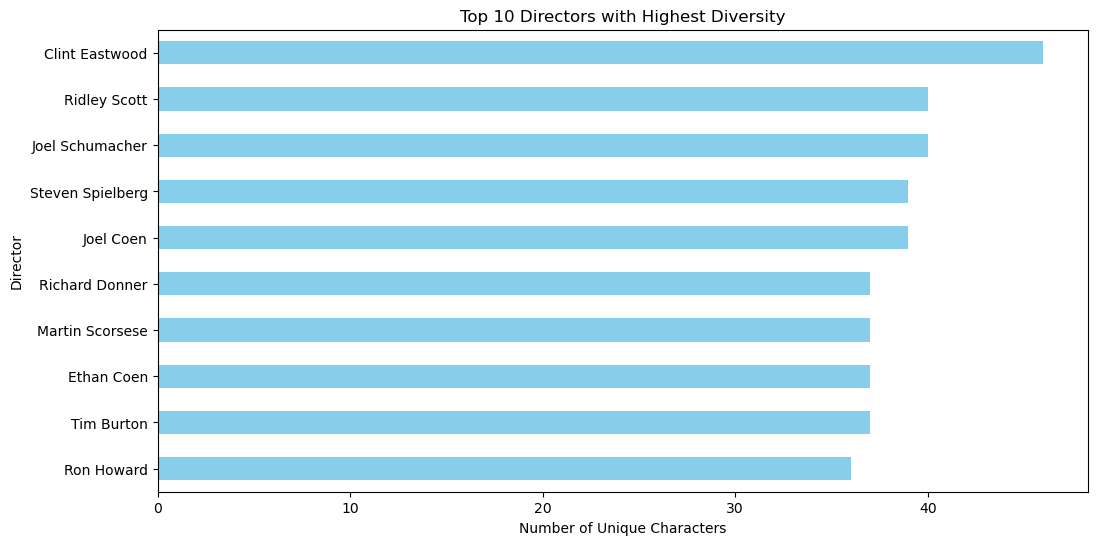

In [50]:
# Calculate the number of unique characters for each director
unique_characters = character_movie_directors.groupby('directors')['topic'].nunique()

# Map director IDs to corresponding 'primaryName'
directors_mapping = character_movie_directors.set_index('directors')['primaryName'].to_dict()
unique_characters.index = unique_characters.index.map(directors_mapping)

# Sort directors based on diversity
sorted_directors = unique_characters.sort_values()

# Visualize the ten directors with the highest diversity
plt.figure(figsize=(12, 6))
sorted_directors.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Directors with Highest Diversity')
plt.xlabel('Number of Unique Characters')
plt.ylabel('Director')
plt.show()

From the above pie chart, we can observe that almost half of the directors only worked with one or two chractor type. However, using this method to define the diversity of directors' chatacter choices  might be subject to the influence of the total number of movies each director has undertaken. To achieve a more precise quantification of the diversity in directors' character choices, we need a more refined quantitative method.

#### Quantify diversity
For quantify diversity, we calculate the Shannon diversity index with normalization for each director based on the distribution of chracter types in their movies. Higher entropy values indicate grater diversity.

In [68]:
# Calculate the Shannon Diversity Index with normalization by the number of chractors
director_diversity = character_movie_directors.groupby('directors')['topic'].apply(lambda x: entropy(pd.Series(x).value_counts() / len(x)))

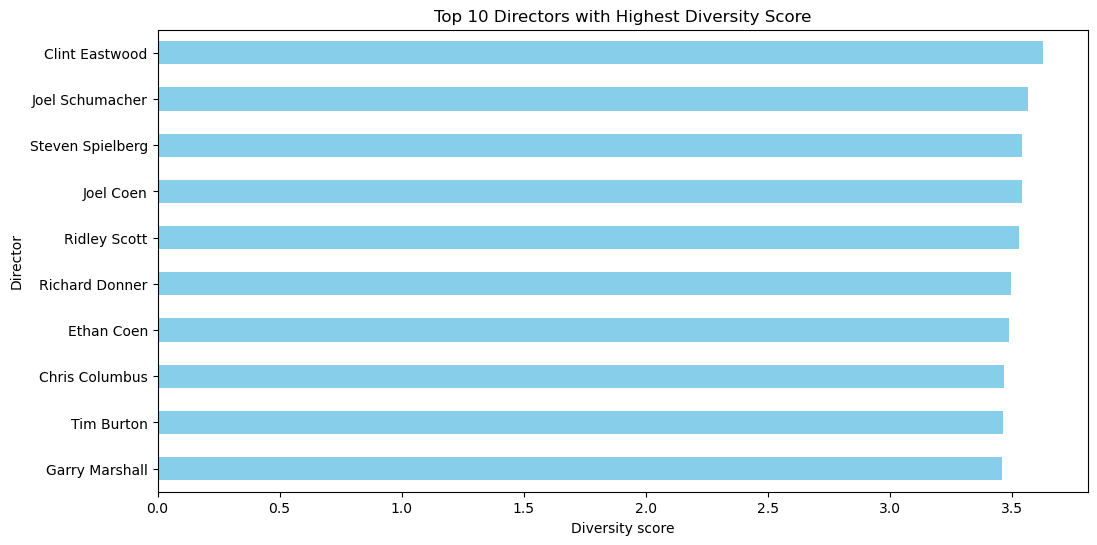

In [71]:
# Visualize the ten directors with the highest diversity

# Map director IDs to corresponding 'primaryName'
director_diversity_map=copy.deepcopy(director_diversity)
director_diversity_map.index = director_diversity_map.index.map(directors_mapping)

# Sort directors based on diversity
sorted_director_diversity = director_diversity_map.sort_values()

plt.figure(figsize=(12, 6))
sorted_director_diversity.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Directors with Highest Diversity Score')
plt.xlabel('Diversity score')
plt.ylabel('Director')
plt.show()

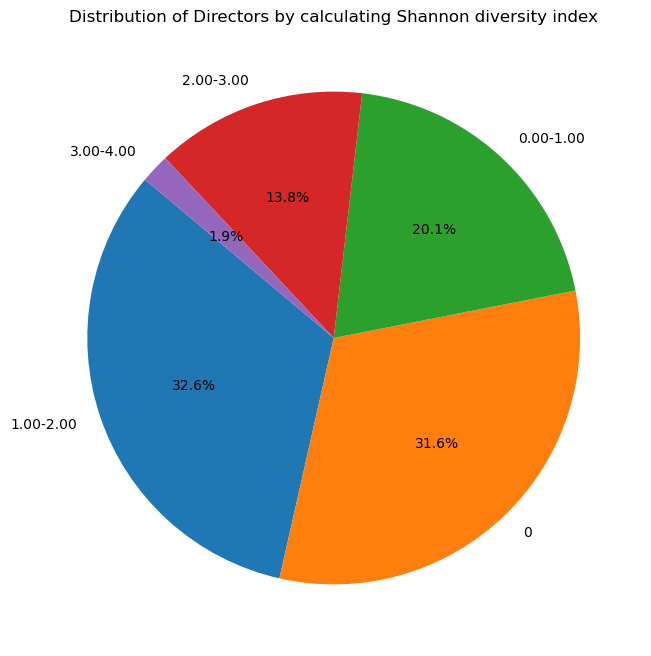

In [86]:
# Create a pie chart to show the distribution of diversity scores

# Define bins for categorizing diversity scores
bins = [-1e-10, 1e-10, 1, 2, 3, 4]  # Adjust the bin edges as needed

# Categorize directors based on diversity scores
diversity_categories = pd.cut(sorted_director_diversity, bins=bins, include_lowest=True)

# Calculate the percentage of directors in each category
percentage_by_category = diversity_categories.value_counts(normalize=False) * 100

labels = [f'{category.left:.2f}-{category.right:.2f}' if category.left > 0 else '0' for category in percentage_by_category.index]
sizes = percentage_by_category.values
colors = plt.cm.tab10(range(len(labels)))

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Directors by calculating Shannon diversity index')
plt.show()

Based on the information presented in the pie chart, it is evident that 32.6% of directors exhibit a diversity score falling within the 1-2 range. Additionally, 31.6% of directors possess a diversity score of 0, indicating that their works predominantly feature a single character type. It's worth noting that this might be influenced by the limitations of the plot data available from CMU, as not all movies and characters have sufficient information to determine character types accurately. In the 0-1 range, 20.1% of directors fall into this category, while 13.8% fall within the 2-3 range. Notably, only 1.9% of directors attain a score of 3-4, indicating a higher diversity of character types in their works.